In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pickle
# from operator import mul

from bi_PE_polytope import PE_analysis
from bi_lib import *

In [7]:
import qutip as qtp
from math import sqrt, pi, cos, sin

def genDistRA(theta, noise=0):
    '''
    Generate the distribution of Hardy paradox used in [arXiv:1810.11648] with some white noise
    '''
    # Define qutip objects, and qubit system
    [id, sx, sy, sz] = [qtp.qeye(2), qtp.sigmax(), qtp.sigmay(), qtp.sigmaz()]
    rho = ((1/sqrt(1+cos(theta)**2))*(cos(theta)*qtp.ket('01') + cos(theta)*qtp.ket('10') + sin(theta)*qtp.ket('11'))).proj()
    rho = (1-noise)*rho + noise*qtp.tensor(id,id)/4

    # Define the projectors for each of the measurements of Alice and Bob
    a00 = (sin(theta)*qtp.ket('0')-cos(theta)*qtp.ket('1')).proj()
    a01 = id - a00
    a10 = (qtp.ket('0')).proj()
    a11 = id - a10
    b00 = (sin(theta)*qtp.ket('0')-cos(theta)*qtp.ket('1')).proj()
    b01 = id - b00
    b10 = (qtp.ket('0')).proj()
    b11 = id - b10
    
    # Collect measurements
    A_meas = [[a00, a01], [a10, a11]]
    B_meas = [[b00, b01], [b10, b11]]

    P = np.zeros((2,2,2,2)) # Behaviour
    for a,b,x,y in it.product(np.arange(2), repeat=4):
        prob = (rho*qtp.tensor(A_meas[x][a], B_meas[y][b])).tr().real
        P[a,b,x,y] = prob
    return P

def SV_set(bias):
    '''
    Return the vertices of the set of allowed distributions 
    for the Santha-Vazirani source with $\delta$=bias.
    '''
    if bias==0:
        return [np.array([[1/4,1/4], [1/4,1/4]])]
    set_p = [[1/2-bias, 1/2+bias],[1/2+bias, 1/2-bias]]
    
    set_p_xy = []
    for px, py in it.product(set_p, repeat=2):
        p_xy = np.zeros((2,2))
        for x,y in it.product(range(2),repeat=2):
            p_xy[x,y] = px[x]*py[y]
        set_p_xy += [p_xy]
        
    return set_p_xy

# Randomness amplification

This is an example code for randomness amplification with noisy Hardy correlations using Santha-Vazirani (SV) input source; see Section 4.2 in our paper. It follows the amplification protocol introduced in [arXiv:1810.11648].

The primary object in our library is a class called 'PE_analysis', which can be defined with (i) some typical correlation of the devices, (ii) input distribution, (iii) input distribution polytope (characterise the set of allowed input distributions), (iv) the choice of the NPA hierarchy level to be used. 'PE_analysis' then takes care of generating polytope-approximations for a given typical correlation, finding optimal PEFs, and calculating the extractable entropy for some given data.

The general process of using our codes is:
1. Define 'PE_analysis' for given typical correlation of the devices and the input distribution.
2. Generate polytope-approximations for the quantum set - where one can use our 'NearV' and 'MaxGP' algorithms to construct polytopes taylored for the typical correlation.
3. Find optimal PEFs using the typical correlation for many different (fixed) powers - this step corresponds to the simpler optimisation in Eq. (18) in our paper. For randomness amplification, the PEF constraint in the optimisation should be replaced by Eq. (38).
4. Randomness accumulation for some given data - this step involves (i) finding the optimal PEF, optimal power, and optimal $\epsilon$ for given data, and (ii) calculating the extractable entropy (rate). The data is typically in the form of counts for each incident (a,b,x,y).

Note that the typical correlation used in step 1-3 is normally different from the data used for randomness accumulation in step 4. The typical correlation can be obtained in advance during the characterisation stage.

Below, we consider the cases with the Hardy correlation with 0.1% white noise and using SV sources with two biases ($\delta$), 0.1 and 0.3. 

In [3]:
### Generating Hardy correlation with 0.1% white noise ###
noise = 0.001 
P_RA_wn_d001 = genDistRA(np.arccos(sqrt((sqrt(5)-1)/2)), noise=noise)
P_xy = np.array([[1/4,1/4],[1/4,1/4]])
N = 10**7
eps = 2**(-32)

### $\delta$ (Bias) = 0.1

In [8]:
RAwnd001_bias_d1 = PE_analysis(P_RA_wn_d001, P_xy, Poly_in=SV_set(0.1))
# We generated the V-representation of the set of allowed distributions for the SV source with bias 0.1
# using the function 'SV_set(bias)' and set it as 'Poly_in' (the set of input distributions).

In [42]:
### Generate various polytopes ###
# NS polytope
RAwnd001_bias_d1.generate_Poly('NS')
# NS+CHSH polytope
RAwnd001_bias_d1.generate_Poly('NS+CHSH')
# 10 iterations of NearV algorithm with cutoff=15
RAwnd001_bias_d1.generate_Poly('NearV', niter=3, cutoff=15) 
# 10 iterations of MaxGP algorithm
RAwnd001_bias_d1.generate_Poly('MaxGP', niter=3, fix_input=(0,0))

=================== NearV algorithm starts ===================
Iteration 0 starts
Chosen index: 0
---------------------
Iteration 1 starts
Chosen index: 7
---------------------
Iteration 2 starts
Chosen index: 5
---------------------
=================== MaxGP algorithm starts ===================
Iteration 0 starts
Chosen input for guessing probability: 0 0
Generating the polytope for optimal solution no.1...
Generating the polytope for optimal solution no.2...
Optimal solution no.2 is quantum. Continue to the next one.
Generating the polytope for optimal solution no.3...
Optimal solution no.3 is quantum. Continue to the next one.
Generating the polytope for optimal solution no.4...
---------------------
Iteration 1 starts
Chosen input for guessing probability: 0 0
Generating the polytope for optimal solution no.1...
Generating the polytope for optimal solution no.2...
Optimal solution no.2 is quantum. Continue to the next one.
Generating the polytope for optimal solution no.3...
Optima

In [43]:
### Opimise PEF for fixed PEF powers ###
RAwnd001_bias_d1.max_power = 0.1 # The maximum power for which we want to optimise PEF
first_power = 0.0001 # The minimum power for which we want to optimise PEF
n_points = 101 # The number of points between the maximum and minimum powers for which we want to optimise PEF

# NS polytope
RAwnd001_bias_d1.get_optF('NS', first_power=first_power, n_points=n_points)

# NS+CHSH polytope
RAwnd001_bias_d1.get_optF('NS+CHSH', first_power=first_power, n_points=n_points)

# NearV algorithm - we only want to optimise PEF for the 3 iterations case -> n_list only has one element '2'. 
RAwnd001_bias_d1.get_optF('NearV', n_list=[2], first_power=first_power, n_points=n_points)

# MaxGP alforithm - we only want to optimise PEF for the 3 iterations case -> n_list only has one element '2'.
RAwnd001_bias_d1.get_optF('MaxGP', n_list=[2], first_power=first_power, n_points=n_points)

=================== Optimise PEF for 'NS' ===================


100%|███████████████████████████████████████| 101/101 [00:27<00:00,  3.65it/s]


=================== Optimise PEF for 'NS+CHSH' ===================


100%|███████████████████████████████████████| 101/101 [00:34<00:00,  2.95it/s]


=================== Optimise PEF for 'NearV' ===================


100%|███████████████████████████████████████| 101/101 [01:19<00:00,  1.27it/s]


=================== Optimise PEF for 'MaxGP' ===================


100%|███████████████████████████████████████| 101/101 [05:22<00:00,  3.19s/it]


In [41]:
### Example code for saving and loading the class

# with open('RAwnd001_bias_d1.pkl', 'wb') as outp:
#     pickle.dump(RAwnd001_bias_d1, outp, pickle.HIGHEST_PROTOCOL)

# with open('RAwnd001_bias_d1.pkl', 'rb') as inp:
#     RAwnd001_bias_d1 = pickle.load(inp)

In [39]:
### Analyse with different N
N_list = [2**n for n in range(10,28)]

RAwnd001_bias_d1_EntR_vs_N_NS = []
RAwnd001_bias_d1_EntR_vs_N_NS_CHSH = []
RAwnd001_bias_d1_EntR_vs_N_NearV = []
RAwnd001_bias_d1_EntR_vs_N_MaxGP = []

for N in N_list:
    ## Generate artificial data
    N_raw = np.reshape([N*P_RA_wn_d001[a,b,x,y]*P_xy[x,y] for a,b,x,y in it.product(range(2),repeat=4)], (2,2,2,2))
    
    # 'NS'
    NS = RAwnd001_bias_d1.randomness_accumulation(N_raw, eps, 'NS', n_list=[0])
    RAwnd001_bias_d1_EntR_vs_N_NS.append(NS[0]['entropy rate'])
    
    # 'NS+CHSH'
    NS_CHSH = RAwnd001_bias_d1.randomness_accumulation(N_raw, eps, 'NS+CHSH', n_list=[0])
    RAwnd001_bias_d1_EntR_vs_N_NS_CHSH.append(NS_CHSH[0]['entropy rate'])
    
    # 'NearV'
    NearV = RAwnd001_bias_d1.randomness_accumulation(N_raw, eps, 'NearV', n_list=[2])
    RAwnd001_bias_d1_EntR_vs_N_NearV.append(NearV[0]['entropy rate'])
    
    # 'NS'
    MaxGP = RAwnd001_bias_d1.randomness_accumulation(N_raw, eps, 'MaxGP', n_list=[2])
    RAwnd001_bias_d1_EntR_vs_N_MaxGP.append(MaxGP[0]['entropy rate'])

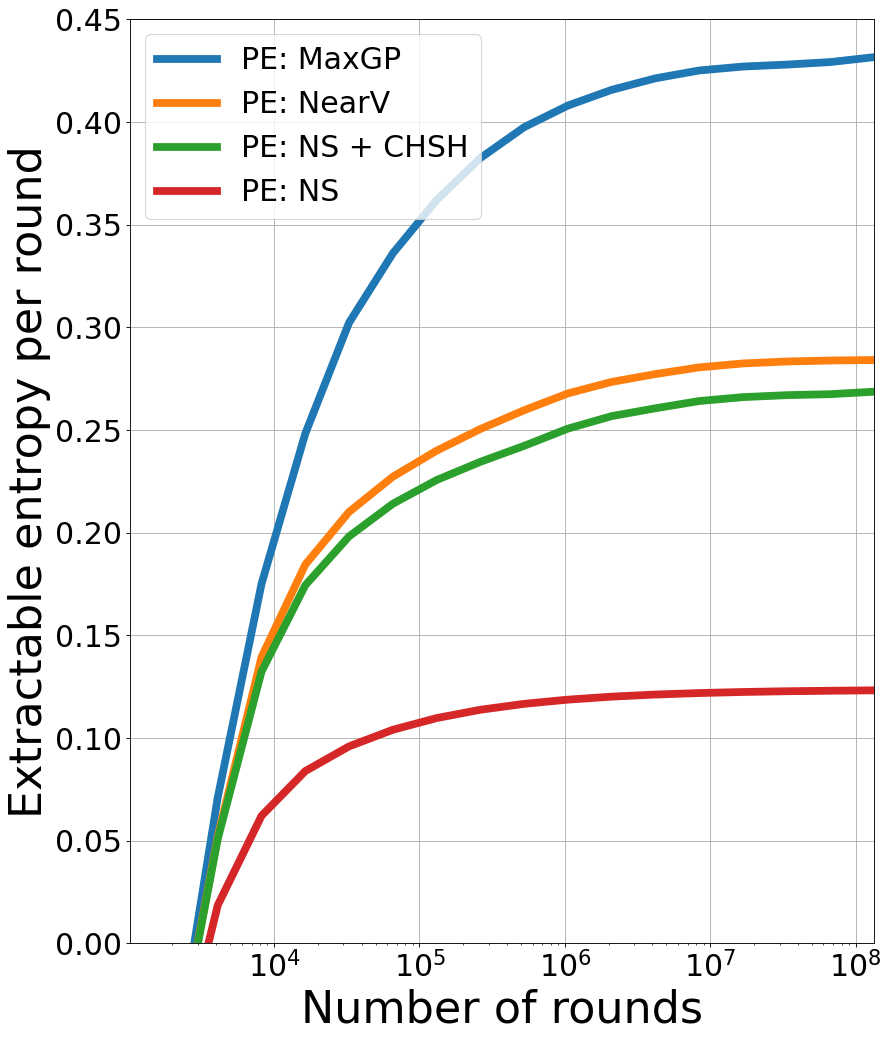

In [40]:
plt.figure(figsize=(12, 15), dpi=80)
plt.rc('font', size=27)

plt.plot(N_list, RAwnd001_bias_d1_EntR_vs_N_MaxGP, linewidth=7)
plt.plot(N_list, RAwnd001_bias_d1_EntR_vs_N_NearV, linewidth=7)
plt.plot(N_list, RAwnd001_bias_d1_EntR_vs_N_NS_CHSH, linewidth=7)
plt.plot(N_list, RAwnd001_bias_d1_EntR_vs_N_NS, linewidth=7)
plt.xscale('log')
plt.xlim([2**10, 2**27])
plt.ylim([0,0.45])
plt.legend(['PE: MaxGP', 'PE: NearV', 'PE: NS + CHSH', 'PE: NS'], prop={'size': 27}, loc=2)
plt.grid()
plt.xlabel('Number of rounds', fontsize=40)
plt.ylabel('Extractable entropy per round', fontsize=40)
plt.show()

### $\delta$ (Bias) = 0.3

In [45]:
RAwnd001_bias_d3 = PE_analysis(P_RA_wn_d001, P_xy, Poly_in=SV_set(0.3))
# The class with the same noisy Hardy correlation (0.1% white noise) but with bias 0.3 in the SV entropy source.

In [61]:
### Generate various polytopes ###
# NS polytope
RAwnd001_bias_d3.generate_Poly('NS')
# NS+CHSH polytope
RAwnd001_bias_d3.generate_Poly('NS+CHSH')
# 10 iterations of NearV algorithm with cutoff=15
RAwnd001_bias_d3.generate_Poly('NearV', niter=3, cutoff=15) 
# 10 iterations of MaxGP algorithm
RAwnd001_bias_d3.generate_Poly('MaxGP', niter=3, fix_input=(0,0))

=================== NearV algorithm starts ===================
Iteration 0 starts
Chosen index: 5
---------------------
Iteration 1 starts
Chosen index: 5
---------------------
Iteration 2 starts
Chosen index: 10
---------------------
=================== MaxGP algorithm starts ===================
Iteration 0 starts
Chosen input for guessing probability: 0 0
Generating the polytope for optimal solution no.1...
Generating the polytope for optimal solution no.2...
Optimal solution no.2 is quantum. Continue to the next one.
Generating the polytope for optimal solution no.3...
Optimal solution no.3 is quantum. Continue to the next one.
Generating the polytope for optimal solution no.4...
---------------------
Iteration 1 starts
Chosen input for guessing probability: 0 0
Generating the polytope for optimal solution no.1...
Generating the polytope for optimal solution no.2...
Optimal solution no.2 is quantum. Continue to the next one.
Generating the polytope for optimal solution no.3...
Optim

In [62]:
### Opimise PEF for fixed PEF powers ###
RAwnd001_bias_d3.max_power = 0.1 # The maximum power for which we want to optimise PEF
first_power = 0.0001 # The minimum power for which we want to optimise PEF
n_points = 101 # The number of points between the maximum and minimum powers for which we want to optimise PEF

# NS polytope
RAwnd001_bias_d3.get_optF('NS', first_power=first_power, n_points=n_points)

# NS+CHSH polytope
RAwnd001_bias_d3.get_optF('NS+CHSH', first_power=first_power, n_points=n_points)

# NearV algorithm - we only want to optimise PEF for the 3 iterations case -> n_list only has one element '2'. 
RAwnd001_bias_d3.get_optF('NearV', n_list=[2], first_power=first_power, n_points=n_points)

# MaxGP alforithm - we only want to optimise PEF for the 3 iterations case -> n_list only has one element '2'.
RAwnd001_bias_d3.get_optF('MaxGP', n_list=[2], first_power=first_power, n_points=n_points)

=================== Optimise PEF for 'NS' ===================


100%|███████████████████████████████████████| 101/101 [00:27<00:00,  3.73it/s]


=================== Optimise PEF for 'NS+CHSH' ===================


100%|███████████████████████████████████████| 101/101 [00:34<00:00,  2.96it/s]


=================== Optimise PEF for 'NearV' ===================


100%|███████████████████████████████████████| 101/101 [00:55<00:00,  1.82it/s]


=================== Optimise PEF for 'MaxGP' ===================


100%|███████████████████████████████████████| 101/101 [05:19<00:00,  3.16s/it]


In [60]:
### Example code for saving and loading the class

# with open('RAwnd001_bias_d3.pkl', 'wb') as outp:
#     pickle.dump(RAwnd001_bias_d3, outp, pickle.HIGHEST_PROTOCOL)

# with open('RAwnd001_bias_d3.pkl', 'rb') as inp:
#     RAwnd001_bias_d3 = pickle.load(inp)

In [58]:
### Analyse with different N
N_list = [2**n for n in range(10,28)]

RAwnd001_bias_d3_EntR_vs_N_NS = []
RAwnd001_bias_d3_EntR_vs_N_NS_CHSH = []
RAwnd001_bias_d3_EntR_vs_N_NearV = []
RAwnd001_bias_d3_EntR_vs_N_MaxGP = []

for N in N_list:
    ## Generate artificial data
    N_raw = np.reshape([N*P_RA_wn_d001[a,b,x,y]*P_xy[x,y] for a,b,x,y in it.product(range(2),repeat=4)], (2,2,2,2))
    
    # 'NS'
    NS = RAwnd001_bias_d3.randomness_accumulation(N_raw, eps, 'NS', n_list=[0])
    RAwnd001_bias_d3_EntR_vs_N_NS.append(NS[0]['entropy rate'])
    
    # 'NS+CHSH'
    NS_CHSH = RAwnd001_bias_d3.randomness_accumulation(N_raw, eps, 'NS+CHSH', n_list=[0])
    RAwnd001_bias_d3_EntR_vs_N_NS_CHSH.append(NS_CHSH[0]['entropy rate'])
    
    # 'NearV'
    NearV = RAwnd001_bias_d3.randomness_accumulation(N_raw, eps, 'NearV', n_list=[2])
    RAwnd001_bias_d3_EntR_vs_N_NearV.append(NearV[0]['entropy rate'])
    
    # 'NS'
    MaxGP = RAwnd001_bias_d3.randomness_accumulation(N_raw, eps, 'MaxGP', n_list=[2])
    RAwnd001_bias_d3_EntR_vs_N_MaxGP.append(MaxGP[0]['entropy rate'])

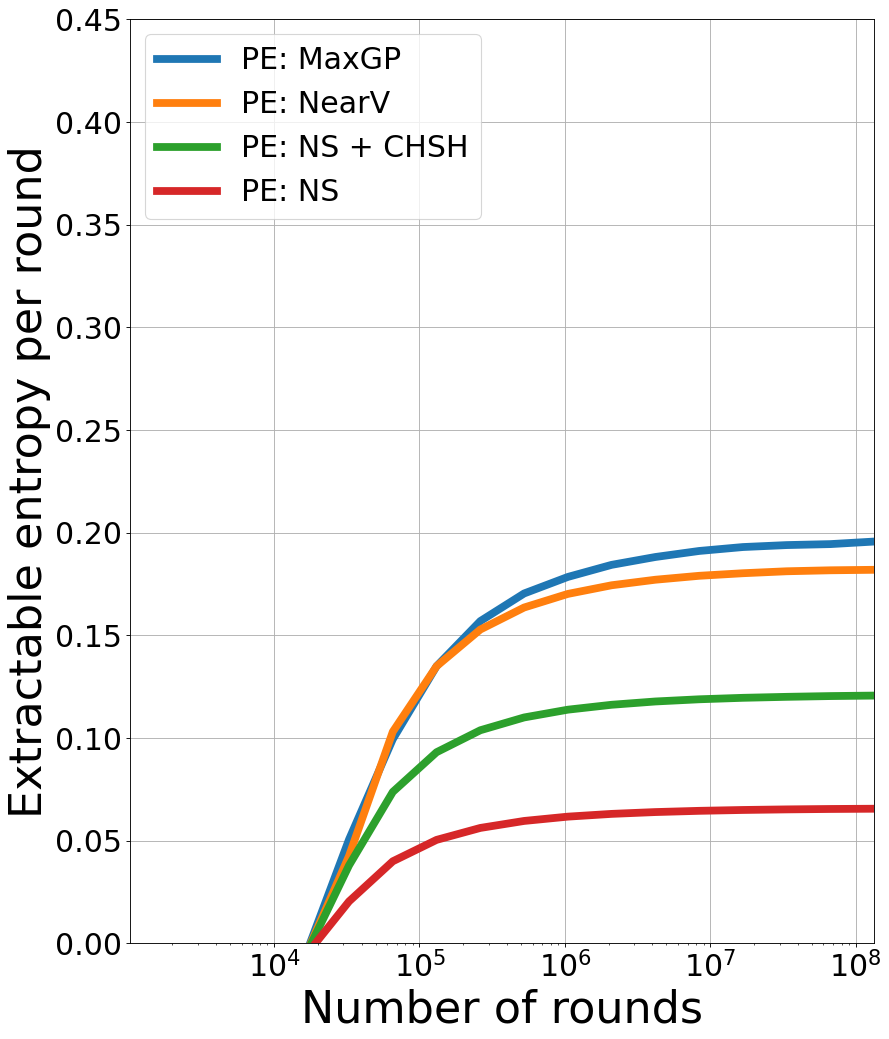

In [59]:
plt.figure(figsize=(12, 15), dpi=80)
plt.rc('font', size=27)

plt.plot(N_list, RAwnd001_bias_d3_EntR_vs_N_MaxGP, linewidth=7)
plt.plot(N_list, RAwnd001_bias_d3_EntR_vs_N_NearV, linewidth=7)
plt.plot(N_list, RAwnd001_bias_d3_EntR_vs_N_NS_CHSH, linewidth=7)
plt.plot(N_list, RAwnd001_bias_d3_EntR_vs_N_NS, linewidth=7)
plt.xscale('log')
plt.xlim([2**10, 2**27])
plt.ylim([0,0.45])
plt.legend(['PE: MaxGP', 'PE: NearV', 'PE: NS + CHSH', 'PE: NS'], prop={'size': 27}, loc=2)
plt.grid()
plt.xlabel('Number of rounds', fontsize=40)
plt.ylabel('Extractable entropy per round', fontsize=40)
plt.show()